# Updating Parquet Files Using Dask

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
import math
import copy

import toolz
import snappy
import fastparquet
import numpy as np
import pandas as pd

In [4]:
# sys.path.append('/Users/vanguiano/Projects/dask/')
import dask
from dask import delayed
import dask.dataframe as dd
import fastparquet

In [59]:
dask.__file__

'/anaconda3/envs/rtu/lib/python3.6/site-packages/dask/__init__.py'

## Motivation
To build our "data lake", a couple of questions need to be answered (and accompanied by Python implementations/prototypes) related to the updating and appending to of Parquet files stored in S3. For an arbitrary dataset, there are four cases that need to be covered:

1. Updating an existing Parquet file when records are added
2. Updating an existing Parquet file when records are deleted
3. Updating an existing Parquet file when records are altered

In addition to meeting the conditions for performing the above operations, questions to considered include:

1. If we use combine_first to update rows (e.g. see [here](https://citybase.atlassian.net/browse/DS-79?focusedCommentId=53549&page=com.atlassian.jira.plugin.system.issuetabpanels:comment-tabpanel#comment-53549)) in an S3+Parquet-backed Dask DataFrame, will actual computations with the result require the entire dataset? More specifically, assuming a dataset is partitioned on disk using separate files, will combine_first only generate graphs that require the files corresponding to the affected partitions? Inspect the resulting graph within DataFrame.dask.  
2. Will an update to disk (i.e. writing back to the S3 Parquet file using to_parquet) require the entire dataset?

Also, we will need to devise a means of applying [DMS-generated updates](https://docs.aws.amazon.com/dms/latest/userguide/CHAP_Target.S3.html).

First, we'll start with a toy dataset with some updates which we will create and upload to S3 as a Parquet file. To start, we will partition into 3 partitions.

In [60]:
toy_data = pd.DataFrame(data=[['Vidal', 1, 'large'],
                              ['Brandon', 2, 'medium'],
                              ['Alex', 3, 'large'],
                              ['Duffy', 4, 'large'],
                              ['Liz', 5, 'small'],
                              ['James', 6, 'large'],
                              ['Jack', 7, 'medium'],
                              ['Jill', 99, 'large'],
                              ['Donna', 9, 'large'],
                              ['Mikey', 10, 'small']], 
                        columns=['name', 'num', 'shirt_size'], index=range(1,11))

# Create Dask DataFrames for above toy data
toy_data_dd = dd.from_pandas(toy_data, 
                             npartitions = 3)
                                
toy_data_dd.to_parquet('s3://cb-pdj-test/toy_data_dd.parq', compression='snappy')

RuntimeError: Need to install `s3fs` library for s3 support
    conda install s3fs -c conda-forge
    or
    pip install s3fs

### Case 1: Updating Existing File With New Records

When updating data to reflect addition of new records, there are two potential scenarios we might encounter.

**1.** When identifying new rows of data to append to our data in S3, one approach for identifying the new rows can involve the use of a timestamp or other indicator that the record is "new". There may also be instances where such timestamp or indicator does not exist, and identifying the new rows necessarily involves comparing the updated data to the older data. For example, if in my older dataset I have 100 records with indices 1-100, and my updated dataset has 105 records with new records having indicies 101-105, we can determine by comparison which records are new. We assume here that old records have not been updated. My hypothesis is that determining which records are new necessarily requires a reading in of the entire dataset and a re-writing of the entire dataset.

**2.** In the second scenario, our new data may come in the form of a "stream" or from a relational database that has a timestamp. Once those "new" records are identified, they can simply be appended to existing Parquet files as new partitions using `to_parquet` argument `append=True`.

#### Scenario 1: Using Combine First to Update 

We start by setting up our "new" dataset, which has two new records with indicies 11 and 12.

In [ ]:
toy_data_new = pd.DataFrame(data=[['Vidal', 1, 'large'],       # Old Records
                                 ['Brandon', 2, 'medium'],    # ...
                                 ['Alex', 3, 'large'],        # ...
                                 ['Duffy', 4, 'large'],       # ...
                                 ['Liz', 5, 'small'],         # ...
                                 ['James', 6, 'large'],       # ...
                                 ['Jack', 7, 'medium'],       # ...
                                 ['Jill', 99, 'large'],       # ...
                                 ['Donna', 9, 'large'],       # ...
                                 ['Mikey', 10, 'small'],      # ...
                                 ['Max', 1, 'small'],         # New Record
                                 ['Madison', 6, 'small']],    # New Record
                        columns=['name', 'num', 'shirt_size'], 
                        index = range(1,13))
toy_data_new_dd = dd.from_pandas(toy_data_new, chunksize=3)

Next, we read in the Parquet file ("old" dataset) and use combine first to combine with the new data. We see in the graph below that all three partitions of `toy_data_dd.parq` are read and merged with the new data. In answer to question number one above, we find that, though there are only updates in this dataset to the last partition, all partitions are read when using `combine_first`.

In [ ]:
# Read in Parquet file from S3
toy_data_rd = dd.read_parquet('s3://cb-pdj-test/toy_data_dd.parq')
print('DIVISIONS OF OLD DATA:', toy_data_dd.divisions)
print('DIVISIONS OF NEW DATA:', toy_data_new_dd.divisions)

# Combine the old data and the new data using combine_first
updated = toy_data_new_dd.combine_first(toy_data_rd)

print('DIVISIONS OF UPDATED :', updated.divisions)
updated.visualize()

In [ ]:
updated.compute()

#### Scenario 2: Appending New Data
In this scenario, I provide an example of appending rows to a dataset. Below we add two records to the Parquet file `toy_data_dd.parq`. Note that the two new records have two distinct indicies not present in the "old" dataset.

In [ ]:
toy_data_append = pd.DataFrame(data=[['Max', 77, 'small'],        # New Record
                                     ['Madison', 56, 'small']],   # New Record
                        columns=['name', 'num', 'shirt_size'], 
                        index = [11,12])
toy_data_append_dd = dd.from_pandas(toy_data_append, npartitions=1)

In [ ]:
toy_data_append_dd.to_parquet('s3://cb-pdj-test/toy_data_dd.parq', compression='snappy', append=True, ignore_divisions = True)

In [ ]:
dd.read_parquet('s3://cb-pdj-test/toy_data_dd.parq').compute()

<br>
<br>
<br>
<br>
<br>

### Case 2: Updating Existing File with Deleted Records

For this case, we use a similar approach to that used in **Case 1, Scenario 1**. To illustrate how dropped records can be retained despite having been deleted in a newer dataset, we use `combine_first` again to get the union of two datasets. In addition to dropping two records, we also add records with indicies 11 and 12.

In [ ]:
toy_data_drop = pd.DataFrame(data=[['Vidal', 1, 'large'],       # Old Records
                                 ['Brandon', 2, 'medium'],    # ...
                                 ['Alex', 3, 'large'],        # ...
                                 ['Duffy', 4, 'large'],       # ...
                              #  ['Liz', 5, 'small'],         # DROP
                                 ['James', 6, 'large'],       # ...
                                 ['Jack', 7, 'medium'],       # ...
                                 ['Jill', 99, 'large'],       # ...
                               # ['Donna', 9, 'large'],       # DROP
                                 ['Mikey', 10, 'small'],      # ...
                                 ['Max', 1, 'small'],         # New Record
                                 ['Madison', 6, 'small']],   # New Record
                        columns=['name', 'num', 'shirt_size'], 
                        index = [1,2,3,4,6,7,8,10,11,12])
toy_data_new_dd = dd.from_pandas(toy_data_drop, chunksize=3)

**NOTE:** As noted in previous work, the result of `combine_first` in this case returns the `num` column as `float` instead of as `int`. The following cell contains code taken from Brandon's `data-frame-updates` APC workaround.

In [ ]:
# Taken from https://github.com/CityBaseInc/data-science-dags/blob/data-frame-updates/citybase_etl/operators/apc.py#L20
update_dtypes = {k: getattr(toy_data_new_dd[k].dtype, 'name', v)
                     for k, v in toy_data_new_dd.dtypes.items()}
toy_data_new_dd = toy_data_new_dd.astype(update_dtypes)

In [ ]:
toy_data_new_dd.compute()

## Digression: Writing Only to Editied Parquet Partitions

As noted in [Case 1](#Case 1: Updating Existing File With New Records), as the `to_parquet` method currently functions, there isn't a way of updating only the specific partitions that contain new or editied data. For example, if I were to append data to an existing dataset with existing indicies, an error is returned. Here is the existing dataframe.

In [61]:
toy_data_dd.to_parquet('./toy_data_dd.parq', compression='snappy')
tdr = dd.read_parquet('./toy_data_dd.parq')
tdr.compute()

,name,num,shirt_size
index,,,
1,Vidal,1,large
2,Brandon,2,medium
3,Alex,3,large
4,Duffy,4,large
5,Liz,5,small
6,James,6,large
7,Jack,7,medium
8,Jill,99,large
9,Donna,9,large


We will now attempt to add two new/updated records having the same indicies as two records that already exist in the dataset, at indicies 5 and 7. Note, we use `append=True`. We get an error as a result.

In [62]:
toy_data_add = pd.DataFrame(data=[['Jim', 1, 'small'],       # New Record
                                  ['Madeline', 6, 'small']], # New Record
                        columns=['name', 'num', 'shirt_size'], 
                        index = [5,7])

# Create Dask DataFrame from toy_data_add
tda = dd.from_pandas(toy_data_add, npartitions=1)

# Append without setting ignore_divisions to False
tda.to_parquet('./test.parq', compression='snappy', append=True)

Repeating the above step, this time adding the argument `ignore_divisions`, the code to append the data works, and results in a new partition being created.

In [63]:
print("PARTITIONS BEFORE:", dd.read_parquet('./test.parq').npartitions,
      "\nDIVISIONS:", dd.read_parquet('./test.parq').divisions)


PARTITIONS BEFORE: 1 
DIVISIONS: (5, 7)


In [64]:
tda.to_parquet('./test.parq', compression='snappy', append=True, ignore_divisions=True)

In [65]:
print("PARTITIONS AFTER:", dd.read_parquet('./test.parq').npartitions,
      "\nDIVISIONS:", dd.read_parquet('./test.parq').divisions)


PARTITIONS AFTER: 2 
DIVISIONS: (None, None, None)


The issue with a new partition being created is that now we have a new partition that does not follow the ordered convention of the other partitions. Furthermore, we lose the divisions indicies in the metadata. Also, now there are two records with the index 5 and index 7. We could technically proceed as is and handle duplicates in the future upon reading in the data, but then we get run into the issue of re-reading and re-writing the entire dataset upon deletion and correction of the indicies all over again.

A desirable feature for updating Parquet files with Dask would be the ability for Dask to update records for indicies that already exist by:
1. Read the Parquet metadata to determine where those indicies are
2. Read in the data for only those partitions
3. Reconcile the changes in within the Pandas dataframe
4. Re-write the partition
5. Update the meta data



### Examining Dask and Fastparquet Source Code

Next, I'll examine the source code for both Dask and Fastparquet to determine where the necessary changes to either may need to be made. The following questions should be addressed:

1. When reading in a Parquet file, where does the meta data get read and how is that meta data represented and used?
2. When appends to Parquet files are made, where in the meta data are there updates and how are they handled?

#### Reading in Parquet Files and Examining Metadata

As can be seen in the [Dask source code](https://github.com/dask/dask/blob/5255092ecb98858451d35efaedb3ae03036870b1/dask/dataframe/io/parquet.py#L177), parquet files are read using the [`ParquetFile`](https://github.com/dask/fastparquet/blob/master/fastparquet/api.py#L25) class from the `fastparquet` package. 

In [66]:
f3 = fastparquet.api.ParquetFile('./toy_data_dd.parq')

The file structure for each `.parq` file is as follows:
- toy_data_dd.parq
    - _common_metadata
    - _metadata
    - **part.0.parquet** | type `fastparquet.parquet_trift.parquet.ttypes.RowGroup`
        - column1, 'index' | type `fastparquet.parquet_thrift.parquet.ttypes.ColumnChunk`  
          .  
          .  
        - column4, 'shirt_size' | type `fastparquet.parquet_thrift.parquet.ttypes.ColumnChunk`  
        <br>
    - **part.1.parquet** | type `fastparquet.parquet_trift.parquet.ttypes.RowGroup`  
        - column1, 'index' | type `fastparquet.parquet_thrift.parquet.ttypes.ColumnChunk`  
          .  
          . 
        - column4, 'shirt_size' | type `fastparquet.parquet_thrift.parquet.ttypes.ColumnChunk`  
        <br>
    - **part.2.parquet** | type `fastparquet.parquet_trift.parquet.ttypes.RowGroup`  
        - column1, 'index' | type `fastparquet.parquet_thrift.parquet.ttypes.ColumnChunk`  
          .  
          .  
        - column4, 'shirt_size' | type `fastparquet.parquet_thrift.parquet.ttypes.ColumnChunk`  

In [67]:
part1 = f3.row_groups[0]

In [68]:
col1 = part1.columns[0]
col1

<class 'fastparquet.parquet_thrift.parquet.ttypes.ColumnChunk'>
file_offset: 61
file_path: part.0.parquet
meta_data: <class 'fastparquet.parquet_thrift.parquet.ttypes.ColumnMetaData'>
  codec: 1
  data_page_offset: 4
  dictionary_page_offset: None
  encoding_stats: [<class 'fastparquet.parquet_thrift.parquet.ttypes.PageEncodingStats'>
count: 1
encoding: 0
page_type: 0
]
  encodings: [3, 4, 0]
  index_page_offset: None
  key_value_metadata: []
  num_values: 4
  path_in_schema: ['index']
  statistics: <class 'fastparquet.parquet_thrift.parquet.ttypes.Statistics'>
    distinct_count: None
    max: b'\x04\x00\x00\x00\x00\x00\x00\x00'
    max_value: None
    min: b'\x01\x00\x00\x00\x00\x00\x00\x00'
    min_value: None
    null_count: 0

  total_compressed_size: 57
  total_uncompressed_size: 63
  type: 2


### Finding: Partitions Overwritable Without Updating Metadata - Kinda
It's possible to write two distinct `.parq` files, swap out a `part.i.parquet` file from one `.parq` folder to another, and sucessfully read in the data with the changes reflected. However, it does have limitations. Anytime the type of a value is changed (ex. changing a string for an integer), it suddently fails to read because the file's data does not match the metadata, which remained unchanged when the file swap was made. Here is an example where we make a change in line 10:

In [ ]:
swap = pd.DataFrame(data=[['Vidal', 1, 'large'],
                          ['Jessica', 2, 'xlarge'],
                          ['Jose', 3, 'small'],
                          ['Brandon', 4, 'medium']], 
                        columns=['name', 'num', 'shirt_size'], index=[1,2,3,4])

swap2 = pd.DataFrame(data=[['Vidal', 1, 'large'],
                           ['Jessica', 2, 'xlarge'],
                           ['Jose', 3, 'small'],
                           ['nodnarB', 455, 'medium']], #****** CHANGE HERE *******#
                        columns=['name', 'num', 'shirt_size'], index=[1,2,3,4])
# Create Dask DataFrame from Pandas
swap_dd = dd.from_pandas(swap, npartitions=2)
swap_dd2 = dd.from_pandas(swap2, npartitions=2)

# Write both Dask DataFrames to Parquet
swap_dd.to_parquet('./swap_test1.parq', compression='snappy')
swap_dd2.to_parquet('./swap_test2.parq', compression='snappy')

print('BEFORE SWAP:---------\n', dd.read_parquet('./swap_test1.parq/').compute(), '\n')

!mv ./swap_test2.parq/part.1.parquet ./swap_test1.parq/

print('AFTER SWAP:----------\n', dd.read_parquet('./swap_test1.parq/').compute())


We can see above that, though we are reading in the same `.parq` file, we see different values for `name` and `num` at index 4 because I swapped the `part.1.parquet`. However, this swapping of files fails when we make the following types of changes, as done in line 10 (all else is the same):

In [ ]:
swap = pd.DataFrame(data=[['Vidal', 1, 'large'],
                          ['Jessica', 2, 'xlarge'],
                          ['Jose', 3, 'small'],
                          ['Brandon', 4, 'medium']], 
                        columns=['name', 'num', 'shirt_size'], index=[1,2,3,4])

swap2 = pd.DataFrame(data=[['Vidal', 1, 'large'],
                           ['Jessica', 2, 'xlarge'],
                           ['Jose', 3, 'small'],
                           ['Brandon', 'hi', 'medium']], #********* CHANGES HERE **********#
                        columns=['name', 'num', 'shirt_size'], index=[1,2,3,4])
# Create Dask DataFrame from Pandas
swap_dd = dd.from_pandas(swap, npartitions=2)
swap_dd2 = dd.from_pandas(swap2, npartitions=2)

# Write both Dask DataFrames to Parquet
swap_dd.to_parquet('./swap_test1.parq', compression='snappy')
swap_dd2.to_parquet('./swap_test2.parq', compression='snappy')

print('BEFORE SWAP:---------\n', dd.read_parquet('./swap_test1.parq/').compute(), '\n')

!mv ./swap_test2.parq/part.1.parquet ./swap_test1.parq/

print('AFTER SWAP:----------\n', dd.read_parquet('./swap_test1.parq/').compute())


Hence, copying partition files from one `.parq` file to another, though it may suggest that we can simply overwrite a single partition without needing to update the metadata, it only works for some situations, and is ultimately **NOT** a solution. 

## Exploring How Append Works
The answer to making updates to partitions while making edits to existing metadata may lie in the code `to_parquet` when for `append=True` `ignore_divisions=False`. First, I want to test if using `append=True` rewrites all of the `part.i.parquet` files by trying a toy example and checking the Date Created timestamps for the files in S3.

In [ ]:
data = pd.DataFrame(data=[['Vidal', 1, 'large'],
                          ['Jessica', 2, 'xlarge'],
                          ['Jose', 3, 'small'],
                          ['Brandon', 4, 'medium']], 
                        columns=['name', 'num', 'shirt_size'], index=[1,2,3,4])

appe = pd.DataFrame(data=[['Jose', 3, 'small'],      #********* APPEND **********#
                          ['Brandon', 7, 'medium']], #********* APPEND **********#
                        columns=['name', 'num', 'shirt_size'], index=[5,6])

data = dd.from_pandas(data, npartitions= 2)
appe = dd.from_pandas(appe, npartitions= 1)
data.to_parquet("s3://cb-pdj-test/append_test.parq", compression='snappy')

In [ ]:
appe.to_parquet("s3://cb-pdj-test/append_test.parq", compression='snappy', append=True)

**Hypothesis Confirmed**: When using `to_parquet` with `append=True`, only the new partition is written and the metadata is created anew, leaving the other partitions untouched. So, in order to figure out how to update specific parititions, I need to identify:
1. How the new partition is written
2. How the metadata is updated
3. Determine if it's possible to change a partition in the middle (if there are three partitions, with file names `part.0.parquet`, `part.1.parquet`, `part.2.parquet` and `part.3.parquet`, is it possible to overwrite `part.2.parquet`, update the metadata accordingly, and still read in the data after the rewriting has happend.

**Answer to 1:** Just as every other partition, use [`_write_partition_fastparquet`](https://github.com/dask/dask/blob/master/dask/dataframe/io/parquet.py#L524) as shown [here](https://github.com/dask/dask/blob/master/dask/dataframe/io/parquet.py#L614) to write the partition.

**Answer to 2:** Metadata is written using [`_write_metadata`](https://github.com/dask/dask/blob/master/dask/dataframe/io/parquet.py#L621) and takes only the new dataframes + filenames along with the metadata from original parquet file as inputs.

**Answer to 3:** It's possible! Use the `.append` and `.pop` methods for `list` of RowObjects in file metadata.  

<br>
<br>
<br>

## Getting Closer: Steps Needed to Update Only Paritions with Updated Data

In order update a parquet file only in the affected partitions, we must:  
1. Use the index value of each updated record to identify which paritions need updating
2. Read in the data in those partitions and reconcile data changes
3. Write the new parition using the filename of the old partition
4. Write the new metadata
    - Drop the partition/row_group from the `fmd`(file metadata) object
    - Append the new `row_group` to the `fmd`
    - Rewrite the metadata files to reflect changes

I will demonstrate updates to an existing parquet file using this toy data:

In [5]:
old_data = pd.DataFrame(data=[['Vidal', 1, 'large'],
                              ['Brandon', 2, 'medium'],
                              ['Alex', 3, 'large'],
                              ['Duffy', 4, 'large'],
                              ['Liz', 5, 'small'],
                              ['James', 6, 'large'],
                              ['Jack', 7, 'medium'],
                              ['Jill', 99, 'large'],
                              ['Donna', 9, 'large'],
                              ['Mikey', 10, 'small']], 
                        columns=['name', 'num', 'shirt_size'], index=range(1,11))

# Create Dask DataFrames for above toy data
old_data_dd = dd.from_pandas(old_data, 
                             npartitions = 3)
                                
%time old_data_dd.to_parquet('./old_data_dd.parq')

CPU times: user 403 ms, sys: 18.1 ms, total: 421 ms
Wall time: 418 ms


We will make updates to the above dataset at indicies 1, 9, and 10 using this data:

In [6]:
new_data = pd.DataFrame(data=[['Vidal', 1, '2xlarge'],
                              ['Liz', 5, 'small'],
                              ['Joe', 8, 'small']], 
                        columns=['name', 'num', 'shirt_size'], index=[1,9,10])

# Create Dask DataFrames for above toy data
new_data_dd = dd.from_pandas(new_data, 
                             npartitions = 1)

In [7]:
# 1a. Grab the index values of the records being updated
new_indicies = list(new_data_dd.compute().index)
print("INDICIES OF CHANGED DATA:", new_indicies)

# 1b. Use those index values to identify the partitions being affected

## Read in the old datasets metadata
old = fastparquet.api.ParquetFile('./old_data_dd.parq')
fmd = old.fmd

## Get index value ranges for each of the partitions in the old dataset
ind = fastparquet.api.sorted_partitioned_columns(old)
indicies = ind['index']
old_indicies = {}
for part_num, index_pair in enumerate(zip(indicies['min'], indicies['max'])):
    old_indicies[part_num] = range(index_pair[0], index_pair[1] + 1)
    
print("INDICIES IN EACH PART OF OLD:", old_indicies)

part_index_map = {}

## Create a dictionary which maps indicies of new data to the partitions which hold the records
## TODO: Look for computationally simpler implementation of this
for oi in old_indicies:
    part_index_map[oi] = set()
    for i in new_indicies:
        if i in set(old_indicies[oi]):
            part_index_map[oi].add(i)
            
print("PARTITIONS AFFECTED:", part_index_map)

INDICIES OF CHANGED DATA: [1, 9, 10]
INDICIES IN EACH PART OF OLD: {0: range(1, 5), 1: range(5, 9), 2: range(9, 11)}
PARTITIONS AFFECTED: {0: {1}, 1: set(), 2: {9, 10}}


#### 2. Read in the data in those partitions and reconcile differences
Using the mapping of paritions to indicies from above, I loop through the mappings to:
- Subset the new data by the indicies according to each partition
- Read in the old data in each partition
- Use combine_first to update the data
- Write the new partition

In [8]:
from dask.dataframe.io.parquet import _write_partition_fastparquet
from dask.bytes.core import get_fs_token_paths
path = './old_data_dd.parq'
partition_on = None
compression = None
storage_options = None
fs, fs_token, _ = get_fs_token_paths(path, mode='wb',
                                         storage_options=storage_options)
sep = fs.sep

writes = []
filenames = []

for part in part_index_map:
    if len(part_index_map[part]) != 0:
        indicies = list(part_index_map[part])
        new_part = new_data_dd.loc[indicies]
        
        filename = 'part.%i.parquet' % part
        old_part = dd.read_parquet(fs.sep.join([path, filename]))
        old = fastparquet.api.ParquetFile('./old_data_dd.parq/' + filename)
        fmd = copy.copy(old.fmd)
        new_part = new_part.combine_first(old_part)
        new_part = new_part.compute().reset_index() 
        print(type(new_part))

        write = _write_partition_fastparquet(new_part, fs, path, filename, fmd, 
                                     compression, partition_on)
        writes.append(write)
        filenames.append(filename)
        print(
            "Partition:", part,
            "\nFile Name:\n", filename,
            "\nOld Data:\n", old_part,
            "\nNew Data:\n", new_part,
            "\n\n\n"
             )


<class 'pandas.core.frame.DataFrame'>
Partition: 0 
File Name:
 part.0.parquet 
Old Data:
 Dask DataFrame Structure:
                 name    num shirt_size
npartitions=1                          
1              object  int64     object
4                 ...    ...        ...
Dask Name: read-parquet, 1 tasks 
New Data:
    index     name  num shirt_size
0      1    Vidal  1.0    2xlarge
1      2  Brandon  2.0     medium
2      3     Alex  3.0      large
3      4    Duffy  4.0      large 



<class 'pandas.core.frame.DataFrame'>
Partition: 2 
File Name:
 part.2.parquet 
Old Data:
 Dask DataFrame Structure:
                 name    num shirt_size
npartitions=1                          
9              object  int64     object
10                ...    ...        ...
Dask Name: read-parquet, 1 tasks 
New Data:
    index name  num shirt_size
0      9  Liz    5      small
1     10  Joe    8      small 





**3. Write the new parition using the filename of the old partition**

This step was completed in the previous cell. To confirm that the partitions wrote successfully, we can read them in individually. We can see the changes reflected below.


In [9]:
dd.read_parquet('./old_data_dd.parq/part.0.parquet').compute()

,name,num,shirt_size
index,,,
1,Vidal,1,2xlarge
2,Brandon,2,medium
3,Alex,3,large
4,Duffy,4,large


In [10]:
dd.read_parquet('./old_data_dd.parq/part.2.parquet').compute()

,name,num,shirt_size
index,,,
9,Liz,5,small
10,Joe,8,small


**4. Write the new metadata**  
   - Drop the partition/row_group from the `fmd`(file metadata) object
   - Append the new `row_group` to the `fmd`

In [11]:
from dask.dataframe.io.parquet import _write_metadata
old = fastparquet.api.ParquetFile('./old_data_dd.parq')
fmd = copy.copy(old.fmd)

partitions = set(range(len(fmd.row_groups)-1))
parts = set([0,2])
parts = partitions - parts

fmd.row_groups = [fmd.row_groups[i] for i in parts]


## Write new metadata
_write_metadata(writes, filenames, fmd, path, fs, sep)

{0, 1}

In [76]:
new_data_dd = new_data_dd.reset_index()
new_data_dd.divisions = (1,10)

## Success!
We can see the changes to the data reflected below. This example demonstrates the ability to modify parquet files at the partition-level in cases where records located in only a few parititons are updated. We are able to update the data without having to read in the entire dataset and without rewriting the entire dataset.

In [77]:
dd.read_parquet('./old_data_dd.parq').compute()

,name,num,shirt_size
index,,,
5,Liz,5,small
6,James,6,large
7,Jack,7,medium
8,Jill,99,large
1,Vidal,1,2xlarge
2,Brandon,2,medium
3,Alex,3,large
4,Duffy,4,large
9,Liz,5,small


In [78]:
%time new_data_dd.to_parquet('./old_data_dd.parq', replace=True)

TypeError: make_metadata() got an unexpected keyword argument 'replace'

In [31]:
import dask.dataframe as dd
import pandas as pd

ORIGINAL_DIV: (1, 3, 5, 7, 9, 10) --- NPARTS: 5
UPDATED__DIV: (1, 4, 7, 10, 12) --- NPARTS: 4
COMBINED_DIV: (1, 3, 4, 5, 7, 9, 10, 12) --- NPARTS: 7


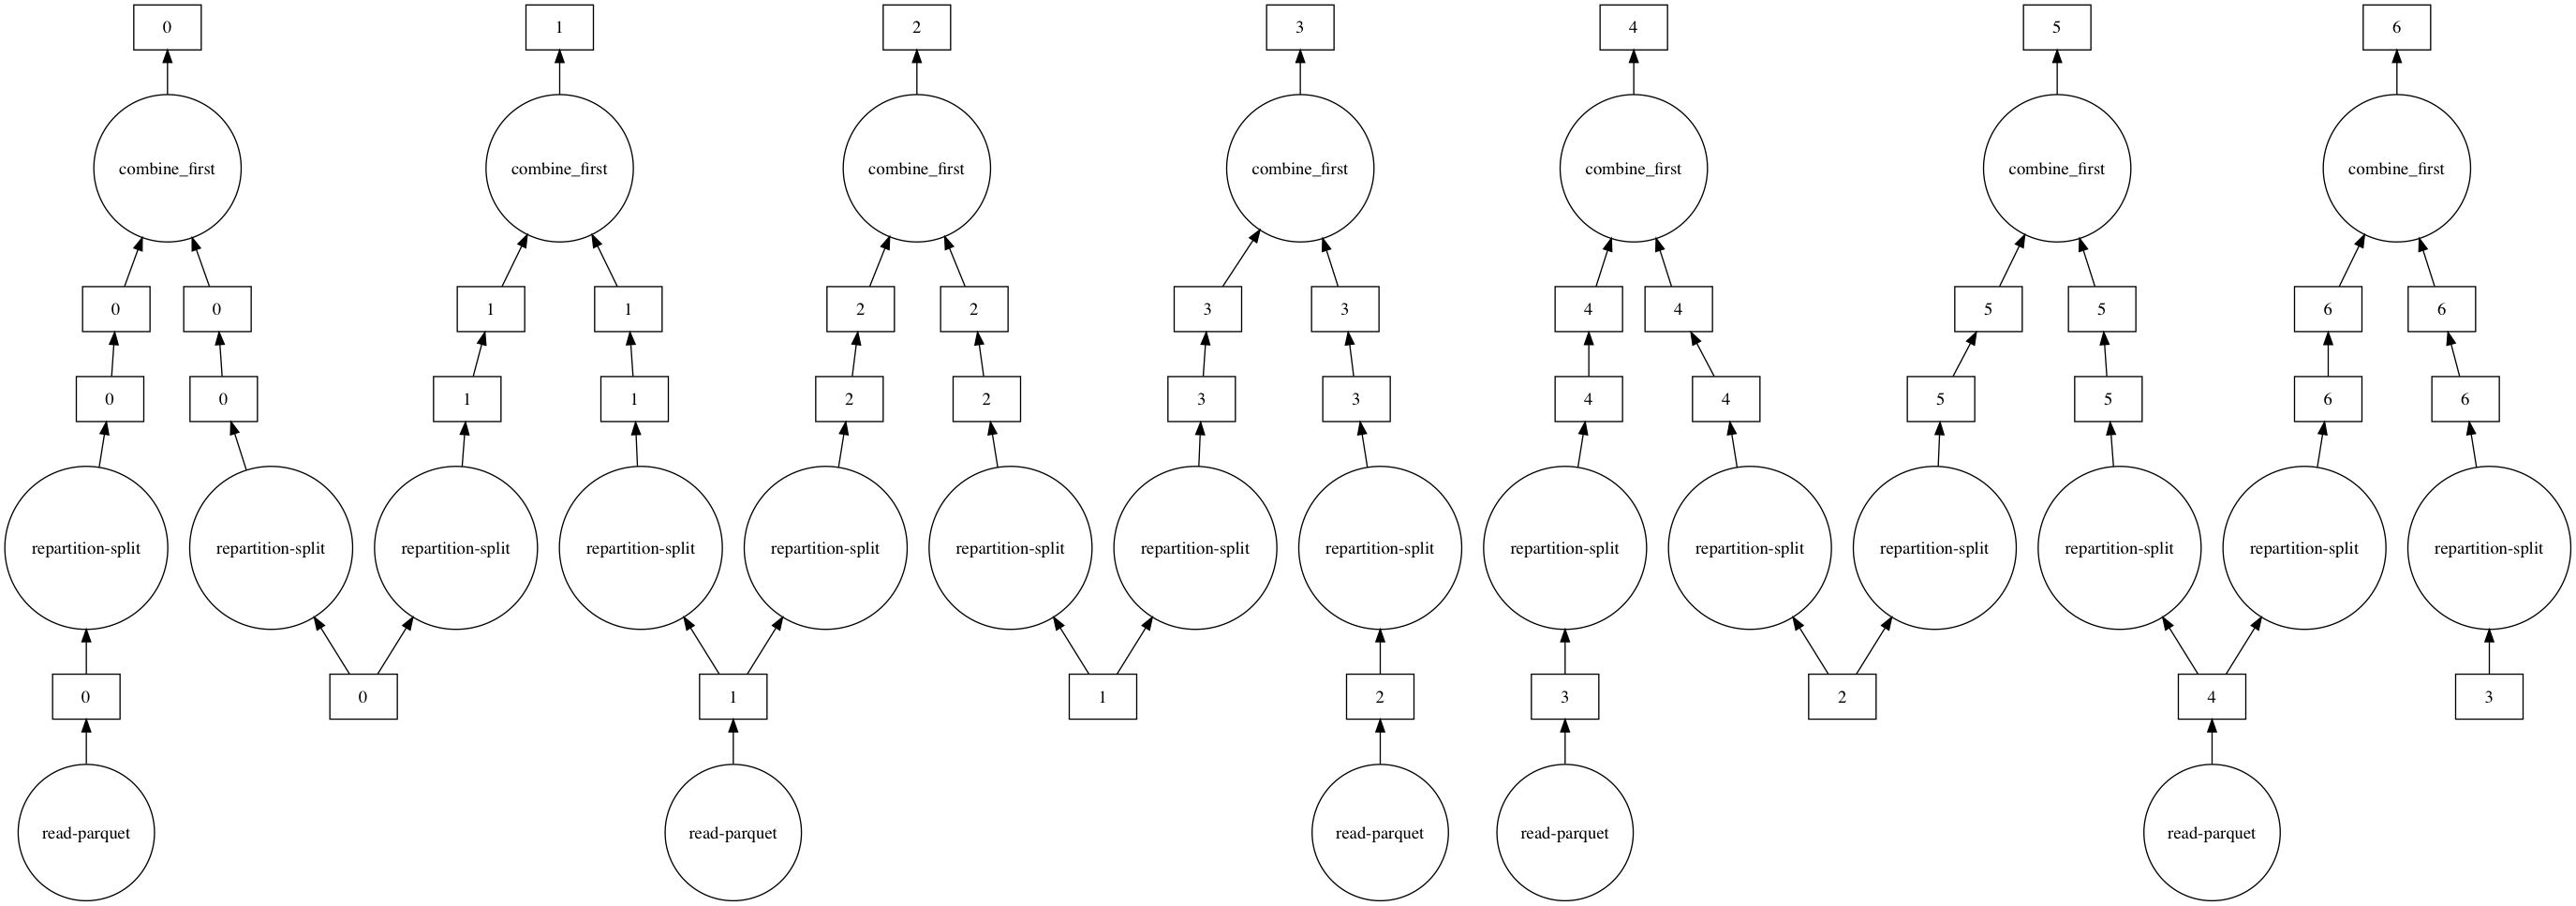

In [24]:
original_data = pd.DataFrame(data=[['Vidal', 1, 'large'],      # Old Records
                                  ['Brandon', 2, 'medium'],    # ...
                                  ['Alex', 3, 'large'],        # ...
                                  ['Duffy', 4, 'large'],       # ...
                                  ['Liz', 5, 'small'],         # ...
                                  ['James', 6, 'large'],       # ...
                                  ['Jack', 7, 'medium'],       # ...
                                  ['Jill', 99, 'large'],       # ...
                                  ['Donna', 9, 'large'],       # ...
                                  ['Mikey', 10, 'small']],      # ...
                             columns=['name', 'num', 'shirt_size'], 
                             index = range(1,11))

original_data_dd = dd.from_pandas(original_data, npartitions=5)
print("ORIGINAL_DIV:", original_data_dd.divisions, "--- NPARTS:", original_data_dd.npartitions)
original_data_dd.to_parquet('./original_data.parq', ignore_divisions=True)
original_data_dd = dd.read_parquet('./original_data.parq')

updated_data = pd.DataFrame(data=[['Vidal', 19, 'large'],      # Old Records
                                  ['Brandon', 2, 'medium'],    # ...
                                  ['Alex', 3, 'large'],        # ...
                                  ['Duffy', 5, 'large'],       # ...
                                  ['Jose', 5, 'small'],         # ...
                                  ['James', 6, 'small'],       # ...
                                  ['Jack', 7, 'medium'],       # ...
                                  ['Jill', 99, 'large'],       # ...
                                  ['Donna', 9, 'large'],       # ...
                                  ['Mikey', 10, 'small'],      # ...
                                  ['Max', 1, 'small'],         # New Record
                                  ['Madison', 6, 'small']],    # New Record
                             columns=['name', 'num', 'shirt_size'], 
                        index = range(1,13))

updated_data_dd = dd.from_pandas(updated_data, npartitions=5)
print('UPDATED__DIV:', updated_data_dd.divisions, "--- NPARTS:", updated_data_dd.npartitions)
print('COMBINED_DIV:', updated_data_dd.combine_first(original_data_dd).divisions, "--- NPARTS:", updated_data_dd.combine_first(original_data_dd).npartitions)

updated_data_dd.combine_first(original_data_dd).visualize()



In [11]:
x = updated_data_dd.combine_first(original_data_dd).dask
x

{('combine_first-a976850fac353a62fe7edeade383c374',
  0): (<function dask.dataframe.core.apply_and_enforce(func, args, kwargs, meta)>, <methodcaller: combine_first>, [('repartition-merge-0fd6b2822b99ba4ac961943c2c0b9e2c',
    0),
   ('repartition-merge-8b30658caf2df7df6af7a1c3ecbb543a', 0)], (dict,
   []), Empty DataFrame
  Columns: [name, num, shirt_size]
  Index: []),
 ('combine_first-a976850fac353a62fe7edeade383c374',
  1): (<function dask.dataframe.core.apply_and_enforce(func, args, kwargs, meta)>, <methodcaller: combine_first>, [('repartition-merge-0fd6b2822b99ba4ac961943c2c0b9e2c',
    1),
   ('repartition-merge-8b30658caf2df7df6af7a1c3ecbb543a', 1)], (dict,
   []), Empty DataFrame
  Columns: [name, num, shirt_size]
  Index: []),
 ('combine_first-a976850fac353a62fe7edeade383c374',
  2): (<function dask.dataframe.core.apply_and_enforce(func, args, kwargs, meta)>, <methodcaller: combine_first>, [('repartition-merge-0fd6b2822b99ba4ac961943c2c0b9e2c',
    2),
   ('repartition-merge-8

In [ ]:
updated_data_dd.combine_first(original_data_dd).compute()

In [2]:
from dask.dataframe.multi import _maybe_align_partitions, align_partitions

In [3]:
align_partitions((original_data_dd, updated_data_dd))[0][0]

NameError: name 'original_data_dd' is not defined

In [22]:
original_data_dd.divisions = (1,10)

In [36]:
original_data_dd.repartition((1,20), force=True).divisions

(1, 20)

In [38]:
ndd = original_data_dd.repartition((1,20,40,100), force=True)

In [55]:
len(ndd.partitions[0])

10

In [56]:
import fastparquet